In [1]:
# input in [x,y,z], assume all the ball are matched (same tracker being imaged)
# camera output
cam_tr1 = [65.934, -116.736, -1281.526]
cam_tr2 = [17.463, -119.529, -1293.654] 
cam_tr3 = [-30.887, -97.887, -1310.197]
cam_tr4 = [-64.618, -148.179, -1310.108]

# CT scan
ct_tr1 = [287, 301, 7]
ct_tr2 = [374, 375, 25]
ct_tr3 = [203, 396, 43]
ct_tr4 = [332, 479, 60]


In [2]:
# To place both camera output and CT scan into one coordinate, we need to define the 
# new coordinate, e.g. the coordinate CT scan use, or a new one. We define the center 
# of the cross to be origin, then tracker2 is +y axis and tracker4 is +x axis. In this 
# case, we only need to rotate the coordinate around one axis at a time. We are going 
# to assume the data for now. 

In [3]:
# helper function 

import numpy as np

# Input: expects 3xN matrix of points
# Returns R,t
# R = 3x3 rotation matrix
# t = 3x1 column vector

def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

In [6]:
# find the transformation matrix given the camera output A and the CT tracker B

import numpy as np

# Test with random data

# Random rotation and translation
R = np.random.rand(3,3)
t = np.random.randint(2000, size=3)

# make R a proper rotation matrix, force orthonormal
U, S, Vt = np.linalg.svd(R)
R = U@Vt

# remove reflection
if np.linalg.det(R) < 0:
   Vt[2,:] *= -1
   R = U@Vt

# number of points
n = 10

A = np.array([cam_tr1, cam_tr2, cam_tr3, cam_tr4]).T
B = R@A + t # ct_normalized_points

# Recover R and t
ret_R, ret_t = rigid_transform_3D(A, B)

# Compare the recovered R and t with the original
B2 = (ret_R@A) + ret_t

# Find the root mean squared error
err = B2 - B
err = err * err
err = np.sum(err)
rmse = np.sqrt(err/n)

print("Camera Ouput (Points A)")
print(A)
print("")

print("TCA results of CT scan (Points B)")
print(B)
print("")

print("Ground truth rotation")
print(R)

print("Recovered rotation")
print(ret_R)
print("")

print("Ground truth translation")
print(t)

print("Recovered translation")
print(ret_t)
print("")

print("RMSE:", rmse)

if rmse < 1e-5:
    print("Everything looks good!")
else:
    print("Hmm something doesn't look right ...")

Camera Ouput (Points A)
[[   65.934    17.463   -30.887   -64.618]
 [ -116.736  -119.529   -97.887  -148.179]
 [-1281.526 -1293.654 -1310.197 -1310.108]]

TCA results of CT scan (Points B)
[[ 97.49648557  69.53612181  59.22143493   5.08876096]
 [ 84.78994867  89.87757225 109.50663869  84.07067674]
 [141.599523   100.40897532  49.53583409  40.06276731]]

Ground truth rotation
[[ 0.64326267  0.64419695 -0.41379151]
 [-0.30450059  0.71111652  0.63371341]
 [ 0.70249023 -0.28164442  0.65359307]]
Recovered rotation
[[ 0.64326267  0.64419695 -0.41379151]
 [-0.30450059  0.71111652  0.63371341]
 [ 0.70249023 -0.28164442  0.65359307]]

Ground truth translation
[[-400]
 [1000]
 [ 900]]
Recovered translation
[[-400.]
 [1000.]
 [ 900.]]

RMSE: 1.5463081705019525e-13
Everything looks good!


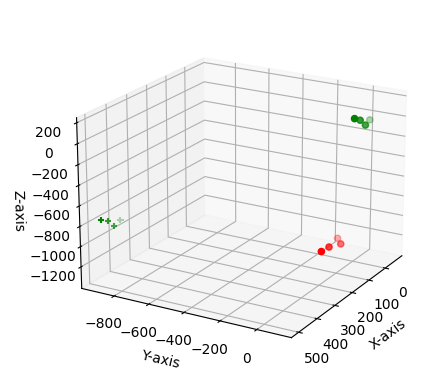

In [5]:
# Map camera output & CT trackers 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the point
ax.scatter(A[0,:],A[1,:],A[2,:], color='red', marker='o')
ax.scatter(B[0,:],B[1,:],B[2,:], color='green', marker='o')
mid = ret_R@A
ax.scatter(mid[0,:],mid[1,:],mid[2,:], color='green', marker='+')

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set the view angles (elevation, azimuth)
ax.view_init(elev=20, azim=30)

# Show the plot
plt.show()


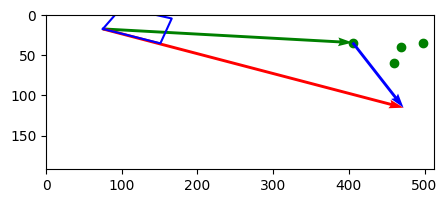

In [9]:
# Map tracker to the bone 

fig = plt.figure(figsize=(5,2))
ax = fig.add_subplot(111)

# plot projection 
ax.scatter(B[0,:]+400,B[1,:]-50, color='green', marker='o')
plt.xlim([0,512])
plt.ylim([0,192])
tr1 = np.array([75,17]) 
ax.plot([75,151,166,100,75],[17,35,4,-10,17], color='blue')     # bone 

ref_tr = [B[0,3]+400, B[1,3]-50]
# plot vectors 
ax.quiver(*tr1, *(ref_tr-tr1),
         angles='xy', scale_units='xy', scale=1, color='green')

# find_angle results 
theta = -1.413716694115407
x0 = -1.2514757203218474 
y0 = 7.901506724761102
slope = np.tan(theta)
stop = np.array([-75*slope+x0, -17*slope+y0])

ax.quiver(*tr1, *(stop-tr1),
         angles='xy', scale_units='xy', scale=1, color='red')

# matrix transformation 
translation_vector = stop-ref_tr
T = np.eye(3)
T[:2,2] = translation_vector 
tr_trsnaformed = np.dot(T, np.append(ref_tr,1))

ax.quiver(*ref_tr, *(tr_trsnaformed[:2]-ref_tr), 
         angles='xy', scale_units='xy', scale=1, color='blue')

# Flip the y-axis limits
ax.invert_yaxis()
plt.show()